#### About this repository:

The notebooks in this repository are meant to serve as comprehensive building blocks for establishing an algorithmic trading system. 
 
A number of sample trading strategies are included, along with methodologies to determine their robustness. Walk-Forward Analysis is one such well known technique, while Combinatorial Purged Cross Validation is a newer and more  rigorous methodology. Another useful and important concept is Meta Labelling, which predicts the probability of individual winning trades. All three techniques are utilized here to help improve the rigor of the systematic trading research process. 

Even though the methodologies presented in these notebooks can always be fine-tuned further, they are sophisticated enough to provide rigorous backtesting of any algorithmic trading strategy. After looking through this repository, one should gain an understanding of how algorithmic trading startegies are programmed and backtested. Identifying such strategies can simply be a matter of adapting algorithms found in research journals or trading websites; the aim of these notebooks is to determine a strategy's profitability and robustness. The final step of live trading a strategy should be merely trivial rewriting of a few lines of code in the Zipline version of the strategy. 


*Hoa Tuan Nguyen:* http://linkedin.com/in/hoatuannguyen/

## Momentum with Bollinger Bands Strategy

This strategy was created to capture the type of large moves we had in March 2020 for BTC. It uses Bollinger-bands indicators. The slow moving average is over the last 5 days (7200 minutes). The fast moving average is over the last 2 hours (120 minutes). The upper and lower bands are slow_mva + - 1.5 * std_slow.

For a sideways market like on in April 2020, the Mean Reversion with Bollinger Bands strategy works quite well. It was thus natural to try combining these two strategies into one that works well for both types of markets. 

For this strategy, when the moving-average price of the last 2 hours breaches either the upper or lower band, a long or short trade is put on with a limit. This is necessary since the 2-hour moving average might be quite far behind the current price that we can trade. I also put a time limit of 30 minutes before canceling an unfilled order.

When this fast mva comes back within the bands, we close the trades. However, since there are times when the fast mva oscillates around either band multiple times in a short period, I put a condition to close a trade only if the current price has actually made a decent move (>=1%) from the level where we put on the trade. I also limit the profit to 7% per trade. Stop loss is at -2%.

A couple data points are kept track of to help make sure the algorithm works as expected.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from datetime import timedelta

from collections import OrderedDict
from datetime import datetime
import pytz

import zipline
from zipline.api import *
from zipline.utils.always_open import AlwaysOpenCalendar

import pyfolio as pf
import empyrical

In [2]:
data = OrderedDict()
data['BTC'] = pd.read_csv("data/btc_2019_aug6_2020.csv",index_col=0,parse_dates=True)

# Zipline only allows trading of whole number of any particular security.
# However, BTC is traded on exchanges in tiny fractions of a single Bitcoin. 
# To allow for realistic backtesting with Zipline, we rescaled the price and volume of BTC
muliplier = 100
data['BTC'].loc[:,'open':'close'] /= muliplier
data['BTC'].volume *= muliplier

panel = pd.Panel(data)
panel.minor_axis = ["open","high","low","close","volume"]
panel.major_axis = panel.major_axis.tz_localize(pytz.utc)

In [3]:
slice_df = data['BTC'].loc['2020-03-01':'2020-04-01']

sma_long = slice_df.close.rolling(7200).mean()
sma_long = sma_long.dropna()

std_long = slice_df.close.rolling(7200).std()
std_long = std_long.dropna()

sma_short = slice_df.close.rolling(120).mean()
sma_short = sma_short.dropna()

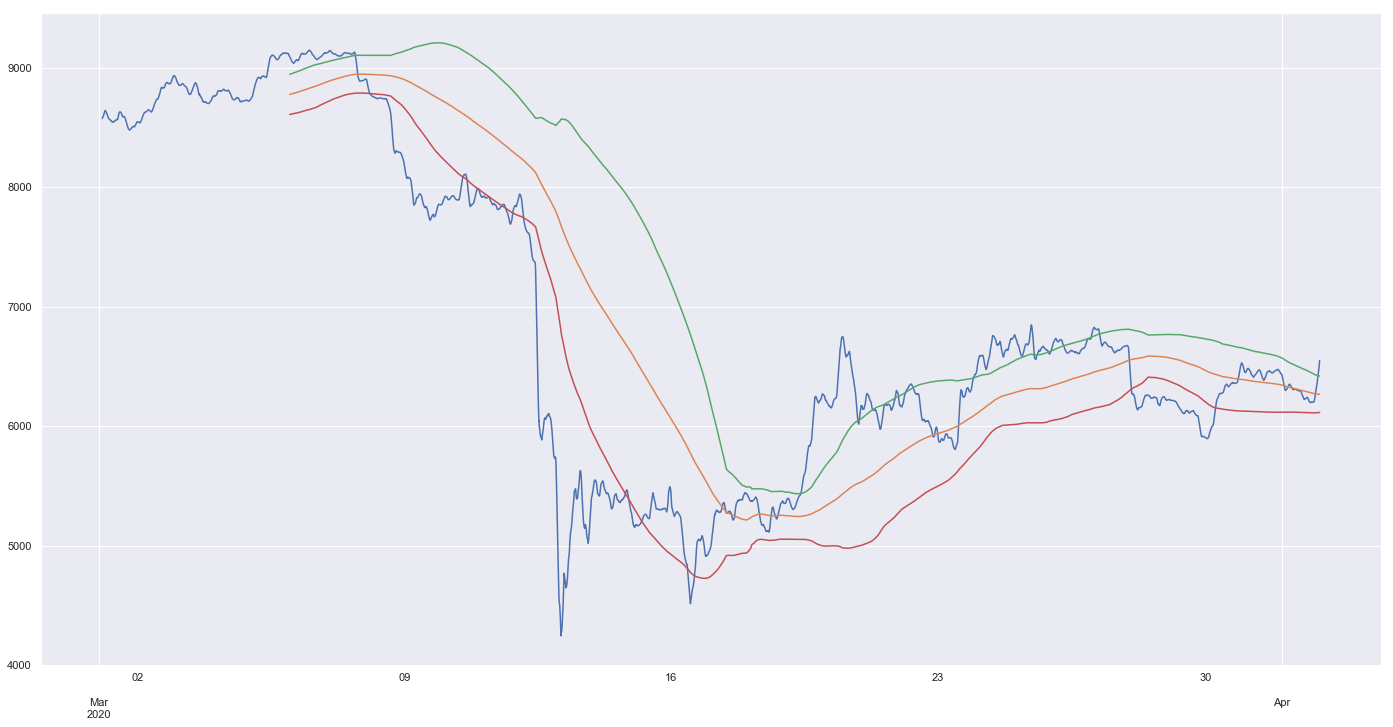

In [4]:
#slice_df.open.plot(figsize=(24,12), alpha=.4)
sma_short.plot(figsize=(24,12))
sma_long.plot()
(sma_long+1*std_long).plot()
(sma_long-1*std_long).plot()

In [9]:
def initialize(context):    
    set_benchmark(symbol('BTC'))
    context.security = symbol('BTC')
    
    context.lower_breached = False
    context.upper_breached = False
    context.can_close = False
    
    context.times_breaches = 0
    context.take_profit = 0
    context.stopped_out = 0
    context.orders_cancelled = 0
    context.pos_ret = 0
    context.neg_ret = 0
    

def handle_data(context, data):
    
    price_history = data.history(
        context.security,
        fields='price',
        bar_count=7200,
        frequency='1m'
    )
    
    #current_price = data.current(context.security, 'price') 
    current_price = price_history[-1]
    
    fast_mva = price_history[-120:].mean()  
    slow_mva = price_history.mean()
    std_price = price_history.std()
    upper = slow_mva + 1.5*std_price
    lower = slow_mva - 1.5*std_price
    
    pos_amount = context.portfolio.positions[context.security].amount
    btc_orders = get_open_orders(context.security)
    open_orders = False if len(btc_orders)==0 else btc_orders[0].status==0
    filled_price = context.portfolio.positions[context.security].cost_basis
   
    # put on trades
    if fast_mva >= upper and not context.upper_breached and not open_orders and not pos_amount:
        order_target_percent(context.security, 1, limit_price=fast_mva*1.01) 
    elif fast_mva <= lower and not context.lower_breached and not open_orders and not pos_amount:
        order_target_percent(context.security, -1, limit_price=fast_mva*.99)
    
    # cancel orders that take too long to execute
    elif open_orders and btc_orders[0].status==0 and get_datetime()-btc_orders[0].created>=timedelta(minutes=30):
        cancel_order(btc_orders[0])
        context.orders_cancelled += 1
    
    # set breached flags:
    elif fast_mva >= upper and not context.upper_breached:
        context.upper_breached = True
        context.times_breaches += 1
    elif fast_mva <= lower and not context.lower_breached:
        context.lower_breached = True
        context.times_breaches += 1
    
    # take profits or stop loss for short positions
    elif context.lower_breached and not open_orders and pos_amount<0:
        prct_changed = (filled_price-current_price)/filled_price
        if not context.can_close and prct_changed >= .01:
            context.can_close = True
        if fast_mva >= lower and context.can_close:
            order_target_percent(context.security, 0)
            context.lower_breached = False
            context.can_close = False
            if prct_changed > 0:
                context.pos_ret += 1
            else:
                context.neg_ret += 1
        else:
            if prct_changed >= .07:
                order_target_percent(context.security, 0)
                context.take_profit += 1
                context.can_close = False
                context.pos_ret += 1
            elif prct_changed <= -.02:
                order_target_percent(context.security, 0)
                context.stopped_out += 1
                context.can_close = False
                context.neg_ret += 1
    
    # take profits or stop loss for long positions
    elif context.upper_breached and not open_orders and pos_amount>0:
        prct_changed = (current_price-filled_price)/filled_price
        if not context.can_close and prct_changed >= .01:
            context.can_close = True
        if fast_mva <= upper and context.can_close:
            order_target_percent(context.security, 0)
            context.upper_breached = False
            context.can_close = False
            if prct_changed > 0:
                context.pos_ret += 1
            else:
                context.neg_ret += 1
        else:
            if prct_changed >= .07:
                order_target_percent(context.security, 0)
                context.take_profit += 1
                context.can_close = False
                context.pos_ret += 1
            elif prct_changed <= -.02:
                order_target_percent(context.security, 0)
                context.stopped_out += 1 
                context.can_close = False
                context.neg_ret += 1
    
    # reset breached flags
    elif fast_mva > lower and fast_mva < upper and context.upper_breached+context.lower_breached:
        context.lower_breached = False
        context.upper_breached = False
    
    record(times_breached = context.times_breaches, canceled = context.orders_cancelled, 
           take_profits = context.take_profit, stopped_out = context.stopped_out,
           pos_ret = context.pos_ret, neg_ret = context.neg_ret)
    

In [10]:
perf = zipline.run_algorithm(start=datetime(2020, 3, 1, 0, 0, 0, 0, pytz.utc),
                      end=datetime(2020, 4, 10, 0, 0, 0, 0, pytz.utc),
                      initialize=initialize,
                      handle_data=handle_data,
                      trading_calendar=AlwaysOpenCalendar(),
                      capital_base=20000,
                      data_frequency ='minute',
                      data=panel)

/anaconda3/envs/env_zipline/lib/python3.5/site-packages/empyrical/stats.py:790: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)


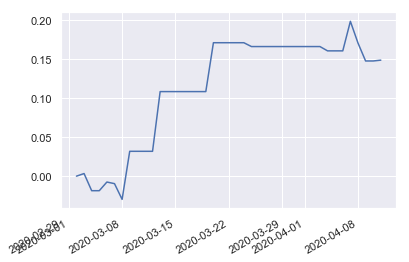

In [11]:
perf.algorithm_period_return.plot()

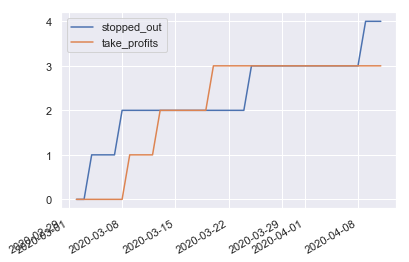

In [12]:
perf.stopped_out.plot()
perf.take_profits.plot()
plt.legend()

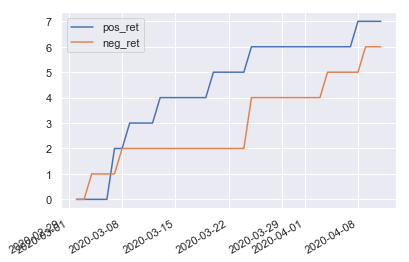

In [13]:
perf.pos_ret.plot()
perf.neg_ret.plot()
plt.legend()

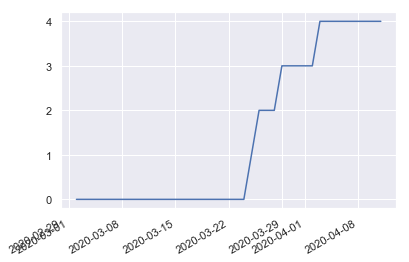

In [14]:
perf.canceled.plot()